In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

In [3]:
import sys
print("Ambiente activo:", sys.executable)

Ambiente activo: /opt/anaconda3/envs/midterm-ml-2025/bin/python


In [4]:
# ========================================
# ECOPETROL + WTI CRUDE (CL=F) - VERSIÓN FINAL
# ========================================

import yfinance as yf
import pandas as pd

#DESCARGAR EC
print("Descargando ECOPETROL (EC)...")
df = yf.download("EC", period="10y", interval="1d", progress=False, auto_adjust=False)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.columns = ['EC_Open', 'EC_High', 'EC_Low', 'EC_Close', 'EC_Volume']
print(f"EC descargado: {len(df)} filas")
print("Columnas EC:", df.columns.tolist())

#DESCARGAR PRECIOS OIL-WTI
print("Descargando WTI Crude Oil (CL=F)...")
wti_df = yf.download("CL=F", period="10y", interval="1d", progress=False, auto_adjust=False)
wti_df = wti_df[['Open', 'High', 'Low', 'Close', 'Volume']]
wti_df.columns = ['WTI_Open', 'WTI_High', 'WTI_Low', 'WTI_Close', 'WTI_Volume']
print(f"WTI descargado: {len(wti_df)} filas")

#ALINEAR OIL-WTI
df['WTI_Close'] = wti_df['WTI_Close'].reindex(df.index).ffill()

#CREAR FEATURES
df['WTI_Change'] = df['WTI_Close'].pct_change()
df['EC_WTI_Ratio'] = df['EC_Close'] / (df['WTI_Close'] + 1e-8)
df['WTI_Volatility'] = df['WTI_Close'].rolling(14).std()

print("\nFeatures de WTI creadas correctamente.")
print(df[['EC_Close', 'WTI_Close', 'EC_WTI_Ratio']].head(3))

#RENOMBRAR PARA ML
df['Close'] = df['EC_Close']  # Para mantener compatibilidad con tu código
df['Volume'] = df['EC_Volume']

#FEATURES TÉCNICAS (SMA, RSI, etc.)
df['SMA_100'] = df['Close'].rolling(100).mean()

def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=periods).mean()
    avg_loss = loss.rolling(window=periods).mean()
    rs = avg_gain / avg_loss
    rs = rs.replace([np.inf, -np.inf], np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df['Close'])

#NUEVAS FEATURES TÉCNICAS
df['Overbought'] = (df['RSI_14'] > 70).astype(int)
df['Oversold'] = (df['RSI_14'] < 30).astype(int)
df['Below_SMA'] = (df['Close'] < df['SMA_100']).astype(int)
df['High_Volume'] = (df['Volume'] > df['Volume'].rolling(20).mean()).astype(int)

#VARIABLE OBJETIVO
df['Tomorrow_Close'] = df['Close'].shift(-1)
df['Target'] = (df['Tomorrow_Close'] < df['Close']).astype(int)  # 1 = baja

#LISTA FINAL DE FEATURES
features = [
    'Close', 'Volume', 'SMA_100', 'RSI_14',
    'Overbought', 'Oversold', 'Below_SMA', 'High_Volume',
    'WTI_Close', 'WTI_Change', 'EC_WTI_Ratio', 'WTI_Volatility'
]

#DATAFRAME PARA ML
df_ml = df[features + ['Target']].copy()
df_ml = df_ml.dropna().reset_index(drop=True)
print(f"\nFilas finales para ML: {len(df_ml)}")
print(f"Correlación EC - WTI: {df['Close'].corr(df['WTI_Close']):.3f}")

Descargando ECOPETROL (EC)...
EC descargado: 2515 filas
Columnas EC: ['EC_Open', 'EC_High', 'EC_Low', 'EC_Close', 'EC_Volume']
Descargando WTI Crude Oil (CL=F)...
WTI descargado: 2515 filas

Features de WTI creadas correctamente.
            EC_Close  WTI_Close  EC_WTI_Ratio
Date                                         
2015-11-02      9.70  46.139999      0.210230
2015-11-03     10.09  47.900002      0.210647
2015-11-04      9.92  46.320000      0.214162

Filas finales para ML: 2409
Correlación EC - WTI: 0.214


In [5]:
print(df[['Close', 'WTI_Close']].head(3))

            Close  WTI_Close
Date                        
2015-11-02   9.70  46.139999
2015-11-03  10.09  47.900002
2015-11-04   9.92  46.320000


In [6]:
df.head(15)

,EC_Open,EC_High,EC_Low,EC_Close,EC_Volume,WTI_Close,WTI_Change,EC_WTI_Ratio,WTI_Volatility,Close,Volume,SMA_100,RSI_14,Overbought,Oversold,Below_SMA,High_Volume,Tomorrow_Close,Target
Date,,,,,,,,,,,,,,,,,,,
2015-11-02,9.29,9.75,9.28,9.70,547900,46.139999,NaN,0.210230,NaN,9.70,547900,NaN,NaN,0,0,0,0,10.09,0
2015-11-03,9.77,10.11,9.71,10.09,791800,47.900002,0.038145,0.210647,NaN,10.09,791800,NaN,NaN,0,0,0,0,9.92,1
2015-11-04,10.11,10.17,9.83,9.92,991400,46.320000,-0.032985,0.214162,NaN,9.92,991400,NaN,NaN,0,0,0,0,9.85,1
2015-11-05,9.84,9.98,9.71,9.85,1378300,45.200001,-0.024180,0.217920,NaN,9.85,1378300,NaN,NaN,0,0,0,0,9.73,1
2015-11-06,9.72,9.81,9.57,9.73,592000,44.290001,-0.020133,0.219688,NaN,9.73,592000,NaN,NaN,0,0,0,0,9.56,1
2015-11-09,9.69,9.80,9.51,9.56,639800,43.869999,-0.009483,0.217917,NaN,9.56,639800,NaN,NaN,0,0,0,0,9.49,1
2015-11-10,9.50,9.58,9.41,9.49,606700,44.209999,0.007750,0.214657,NaN,9.49,606700,NaN,NaN,0,0,0,0,9.21,1
2015-11-11,9.48,9.52,9.12,9.21,984500,42.930000,-0.028953,0.214535,NaN,9.21,984500,NaN,NaN,0,0,0,0,8.87,1
2015-11-12,9.04,9.09,8.76,8.87,1287300,41.750000,-0.027487,0.212455,NaN,8.87,1287300,NaN,NaN,0,0,0,0,8.72,1


ANÁLISIS EXPLORATORIO DE DATOS (EDA)


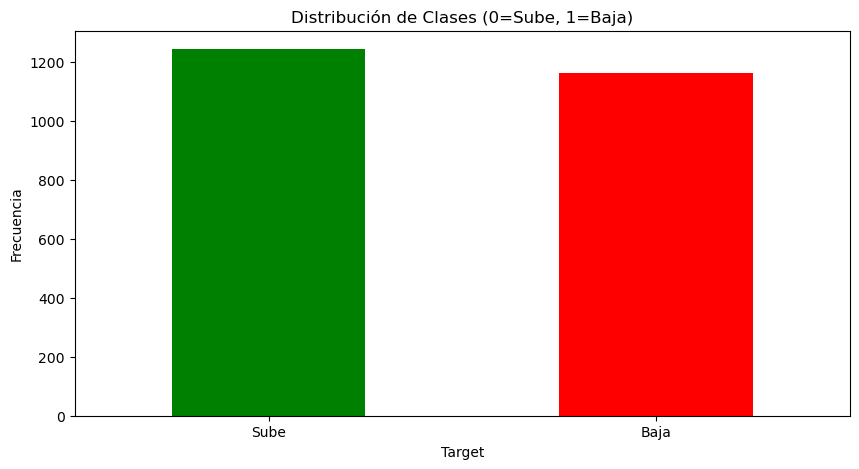

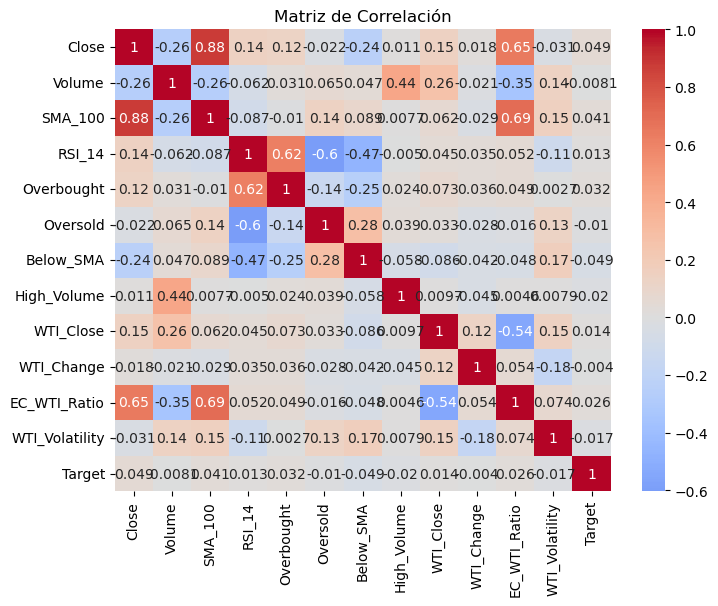

In [7]:
# --- 5. EDA ---
print("ANÁLISIS EXPLORATORIO DE DATOS (EDA)")

# Distribución del target

plt.figure(figsize=(10,5))
df_ml['Target'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribución de Clases (0=Sube, 1=Baja)')
plt.xticks([0,1], ['Sube', 'Baja'], rotation=0)
plt.ylabel('Frecuencia')
plt.show()

# Correlación
plt.figure(figsize=(8,6))
sns.heatmap(df_ml[features + ['Target']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

In [8]:
# --- 6. DIVISIÓN TRAIN/TEST ---
X = df_ml[features]
y = df_ml['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # ¡Importante: serie temporal!
)

print(f"Train: {len(X_train)} | Test: {len(X_test)}\n")

Train: 1927 | Test: 482



In [9]:
# --- 7. BASELINE MODEL ---
baseline_acc = max(y_test.value_counts()) / len(y_test)
print(f"Baseline (predicción mayoritaria): {baseline_acc:.3f}\n")

Baseline (predicción mayoritaria): 0.523



In [10]:
# --- 8. ENTRENAR MÚLTIPLES MODELOS ---
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.3f}")


Logistic Regression: 0.525
Random Forest: 0.508
KNN: 0.529
XGBoost: 0.517


/opt/anaconda3/envs/midterm-ml-2025/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:44:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [11]:
#ENTRENAR Y COMPARAR 4 MODELOS ---
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.3f}")

#MEJOR MODELO ---
best_name = max(results, key=results.get)
best_model = models[best_name]
print(f"\nMEJOR MODELO: {best_name} → {results[best_name]:.3f}")

Logistic Regression: 0.525
Random Forest: 0.508
KNN: 0.529
XGBoost: 0.517

MEJOR MODELO: KNN → 0.529


/opt/anaconda3/envs/midterm-ml-2025/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:44:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
              precision    recall  f1-score   support

        Sube       0.54      0.60      0.57       252
        Baja       0.51      0.45      0.48       230

    accuracy                           0.53       482
   macro avg       0.53      0.53      0.52       482
weighted avg       0.53      0.53      0.53       482



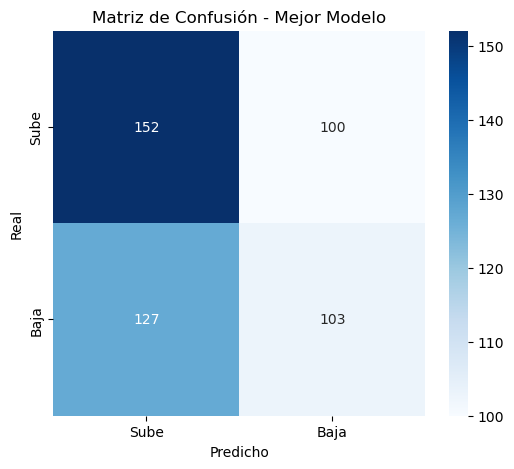

In [12]:
#EVALUACIÓN DETALLADA
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Sube', 'Baja']))

#Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sube', 'Baja'], yticklabels=['Sube', 'Baja'])
plt.title('Matriz de Confusión - Mejor Modelo')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

In [13]:
#GUARDAR MODELO
os.makedirs('data', exist_ok=True)
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(features, 'data/features.pkl')
print("\nModelo guardado como 'best_model.pkl'")


Modelo guardado como 'best_model.pkl'


In [14]:
#EXPORTAR DATOS
df_ml.to_csv('data/EC_processed.csv', index=True)
print("Datos procesados guardados en 'data/EC_processed.csv'")

Datos procesados guardados en 'data/EC_processed.csv'


In [15]:
print("Columnas en df original:", df.columns.tolist())
print("Columnas en df_ml:", df_ml.columns.tolist())
print("Filas en df_ml después de dropna:", len(df_ml.dropna()))

Columnas en df original: ['EC_Open', 'EC_High', 'EC_Low', 'EC_Close', 'EC_Volume', 'WTI_Close', 'WTI_Change', 'EC_WTI_Ratio', 'WTI_Volatility', 'Close', 'Volume', 'SMA_100', 'RSI_14', 'Overbought', 'Oversold', 'Below_SMA', 'High_Volume', 'Tomorrow_Close', 'Target']
Columnas en df_ml: ['Close', 'Volume', 'SMA_100', 'RSI_14', 'Overbought', 'Oversold', 'Below_SMA', 'High_Volume', 'WTI_Close', 'WTI_Change', 'EC_WTI_Ratio', 'WTI_Volatility', 'Target']
Filas en df_ml después de dropna: 2409


In [16]:
#VER DISTRIBUCIÓN DE CLASES
print("Distribución en TEST:")
print(y_test.value_counts(normalize=True).round(3))

#RESULTADOS DE TUS MODELOS
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: {acc:.3f}")

Distribución en TEST:
Target
0    0.523
1    0.477
Name: proportion, dtype: float64
Logistic Regression: 0.525
Random Forest: 0.508
KNN: 0.529
XGBoost: 0.517


/opt/anaconda3/envs/midterm-ml-2025/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:44:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [17]:
# GUARDAR LOS DATOS PARA EL CONTENEDOR
df_ml.to_csv('data/df_ml.csv', index=False)
print("Datos guardados en data/df_ml.csv")

Datos guardados en data/df_ml.csv
